### Описание задачи

В некой стране Компания производит различные товары-сладости (SKU) и осуществляет продажу в 4х туристических городах (локациях), где количество и тип потребителей меняется от месяца к месяцу. Основную часть ассортимента Компании составляет шоколад, а основной объем продаж приходится на город Alpha City.

Компании доступно 2 источника информации, оба помесячные: внутренние данные по отгрузкам и розничным ценам в каждом из 4х городов, а также внешние данные, которые компания закупает у стороннего подрядчика, по количеству и типам клиентов в городах. 

Данные по продажам - sales.tsv  
Данные по потоку потребителей - customers.tsv

 - sku_id = уникальный идентификатор одной позиции товара (SKU = Stock Keeping Unit).  
 - ira = International Retail Association  = уникальный код локации согласно классификации международной ассоциации ретейлеров.  
 - product_category – категория продукта.  
 - item_per_bundle – количество единиц товара на 1 упаковку (например, бывают наборы по 3 шоколадки сразу).  
 - shape – форма упаковки.  
 - with_alcohol – содержит ли алкоголь в начинке (yes/no).  
 - filling – начинка.  
 - volume – объем продаж в штуках.  
 - price – цена 1 штуку товара в USD.  

Данные по типу и количеству клиентов (потоку клиентов), имеет глубокую экспертизу и дополнительные внешние источники (например, забронированные путевки), на основании которых предоставляет как фактические данные (до июня 2019 года включительно), так и достаточно точной прогноз на 3 месяца вперед (июль-сентября 2019)

Сейчас 01 июля 2019 года, Компания только что получила свежие данные по продажам до июня включительно. Вас, как специалиста по продвинутой аналитике, наняли для того, чтобы найти алгоритм, максимально точно описывающий поведение рынка, то есть зависимость продаж каждой позиции товара в каждой локации от различных факторов. 

## Задача 1

Сейчас 01 июля 2019 года, нужно спрогнозировать продажи по каждому SKU в ассортименте для каждой локации на 3 месяца вперед помесячно (июль, август, сентябрь) с предположением, что цены останутся неизменными по сравнению с последним месяцем.Точность оценивается по метрике SMAPE.  
Если для какого-то SKU в какой-то локации прогноз сделать невозможно, необходимо указать причину.

In [1]:
#pip install -r requirements.txt

In [2]:
#pip install math

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import math

In [4]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


#### Загрузка данных

In [2]:
df_s = pd.read_csv("data/sales.tsv", sep='\t')

In [3]:
df_c = pd.read_csv("data/customers.tsv", sep='\t')

In [4]:
df_s.head()

,year,month,location,ira,product_category,brand,sku_id,item_per_bundle,shape,with_alcohol,filling,volume,price
0,2017,1,Alpha City,AC,Chocolates,Cadbury,sku #79,1,Standart,No,Nothing,4572.0,NaN
1,2017,1,Alpha City,AC,Chocolates,Ferrero Rocher,sku #15,1,Standart,No,Nothing,8028.0,1.221336
2,2017,1,Alpha City,AC,Chocolates,Ferrero Rocher,sku #16,3,Standart,No,Nothing,6606.0,2.866401
3,2017,1,Alpha City,AC,Chocolates,Ferrero Rocher,sku #22,2,Standart,No,Nothing,11688.0,2.093719
4,2017,1,Alpha City,AC,Chocolates,Ferrero Rocher,sku #28,3,Standart,No,Nothing,3582.0,2.866401


In [5]:
df_c.head()

,year,month,ira,customers_type,amount_of_customers
0,2017,1,AC,Archer,679.0
1,2017,1,AC,Monk,1070.0
2,2017,1,AC,Dwarf,610.0
3,2017,1,AC,Centaur,1315.0
4,2017,1,AC,Gremlin,1554.0


#### Работа с пропусками значений

In [9]:
df_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1980 entries, 0 to 1979
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 1980 non-null   int64  
 1   month                1980 non-null   int64  
 2   ira                  1980 non-null   object 
 3   customers_type       1980 non-null   object 
 4   amount_of_customers  1980 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 77.5+ KB


In [10]:
df_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1729 entries, 0 to 1728
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              1729 non-null   int64  
 1   month             1729 non-null   int64  
 2   location          1729 non-null   object 
 3   ira               1729 non-null   object 
 4   product_category  1729 non-null   object 
 5   brand             1729 non-null   object 
 6   sku_id            1729 non-null   object 
 7   item_per_bundle   1729 non-null   int64  
 8   shape             1729 non-null   object 
 9   with_alcohol      1729 non-null   object 
 10  filling           1729 non-null   object 
 11  volume            1729 non-null   float64
 12  price             1617 non-null   float64
dtypes: float64(2), int64(3), object(8)
memory usage: 175.7+ KB


In [11]:
df_s.isnull().sum()

year                  0
month                 0
location              0
ira                   0
product_category      0
brand                 0
sku_id                0
item_per_bundle       0
shape                 0
with_alcohol          0
filling               0
volume                0
price               112
dtype: int64

 Есть пропуски только по ценам (price), посмотрю на эти данные подробнее:

Группировка по товарам с отсутствием записей по ценам:

In [12]:
df_s[df_s.isnull().any(axis=1)]['sku_id'].value_counts()

sku #78     24
sku #79     24
sku #84     12
sku #81     12
sku #82     12
sku #83     12
sku #106     8
sku #97      4
sku #94      3
sku #100     1
Name: sku_id, dtype: int64

По городам:

In [13]:
df_s[df_s.isnull().any(axis=1)]['location'].value_counts()

Moon          48
Alpha City    35
Pirate Bay    29
Name: location, dtype: int64

По годам и месяцам:

In [14]:
df_s[df_s.isnull().any(axis=1)].groupby(['year', 'month'])['sku_id'].count()

year  month
2017  1         8
      2         8
      3         8
      4         8
      5         8
      6         8
      7         8
      8         9
      9        11
      10       11
      11       12
      12       13
Name: sku_id, dtype: int64

Данных не хватает только в 2017 году и в каждом месяце примерно равное количетво пропусков.

In [6]:
df_s['is_nan'] = df_s['price'].apply(lambda x: math.isnan(x))

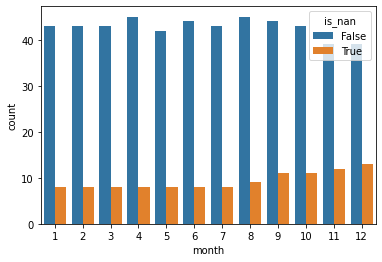

In [16]:
sns.countplot(data=df_s[df_s['year']==2017], x='month', hue='is_nan');

В среднем по месяцам почти 10% данных пустые за 2017 год

In [17]:
df_s['price'].describe()

count    1617.000000
mean        1.583406
std         0.629972
min         1.031200
25%         1.246254
50%         1.295835
75%         1.438110
max         3.632387
Name: price, dtype: float64

Заменю пропуски цен на 0 и посмотрю "просадки" на графиках

In [7]:
df_s['price'].fillna(0, inplace=True)

In [8]:
df_s['price'].isna().sum()

0

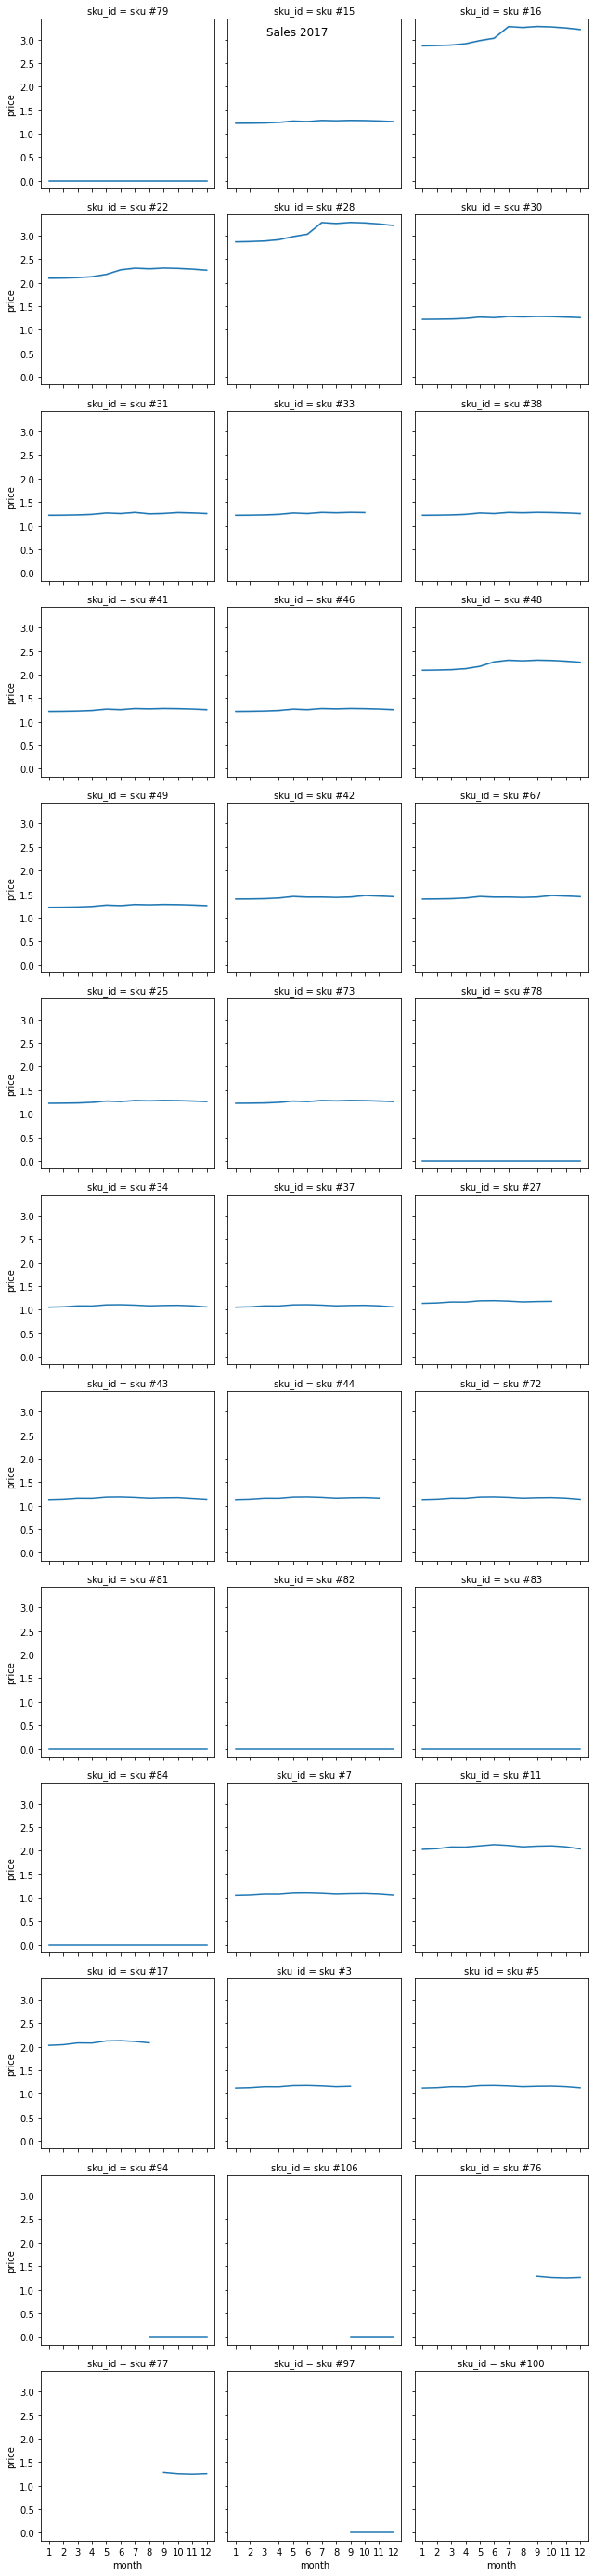

In [56]:
g = sns.FacetGrid(df_s[(df_s['year']==2017)], col="sku_id", col_wrap=3, height=3, margin_titles=True, despine=False)
g.fig.suptitle('Sales 2017')
g.set(xticks=range(1,13))
g.map(sns.lineplot, "month", "price");

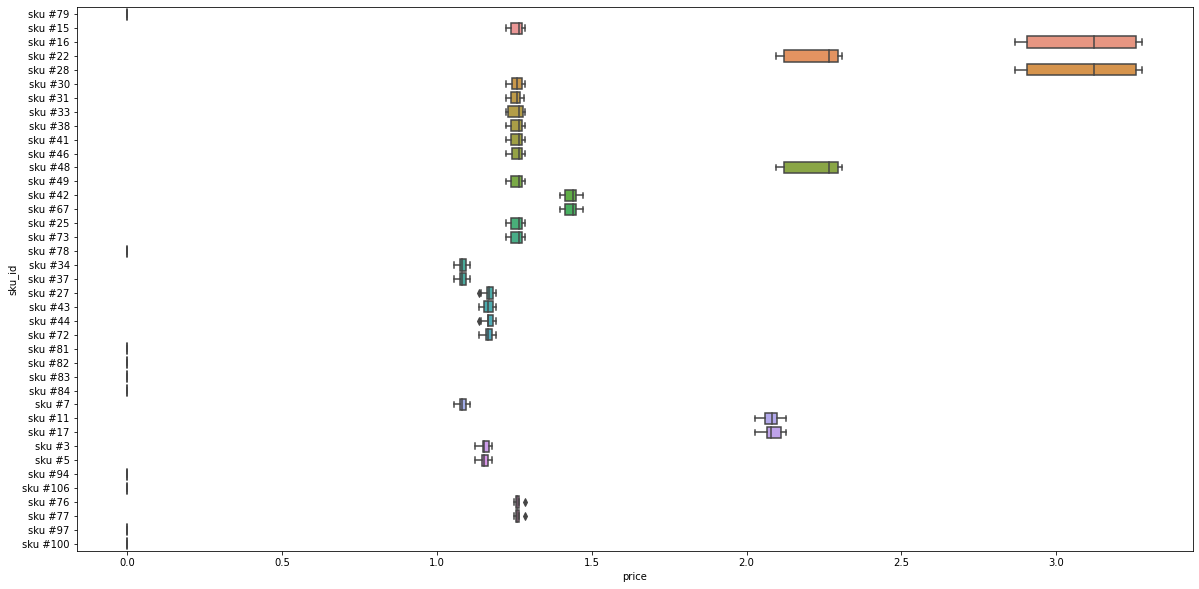

In [21]:
fsize = (20, 10)
fig, ax = plt.subplots(figsize=fsize)
sns.boxplot(data=df_s[(df_s['year']==2017)], y='sku_id', x='price');

Т.к. цена положительаня величина, то если среднее значение равно нулю, то у этого товара за выбранный период только пропуски по цене, выберу их:

In [8]:
df_sku_nan = df_s[(df_s['year']==2017)].groupby(['sku_id']).filter(lambda x: x['price'].mean() == 0.)['sku_id'].value_counts().reset_index()
df_sku_nan

,index,sku_id
0,sku #78,24
1,sku #79,24
2,sku #83,12
3,sku #84,12
4,sku #81,12
5,sku #82,12
6,sku #106,8
7,sku #97,4
8,sku #94,3
9,sku #100,1


In [23]:
df_s[df_s['sku_id'].isin(df_sku_nan['index'].values)].groupby(['sku_id'])['volume'].sum()

sku_id
sku #100     66132.0
sku #106     87234.0
sku #78     124620.0
sku #79     282636.0
sku #81     120684.0
sku #82      60744.0
sku #83      77562.0
sku #84      87870.0
sku #94      25686.0
sku #97     166422.0
Name: volume, dtype: float64

Полностью сходится с количеством NaN, значит нет товаров у которых цен нет частично за 2017 год, если NaN, то цен товара нет вообще, т.е. получается, что у этих товаров вообще нет никаких данных по ценам за 2017, при этом есть продажи, значит цену по каким то причинам не указали.

#### Более подробно о продажах

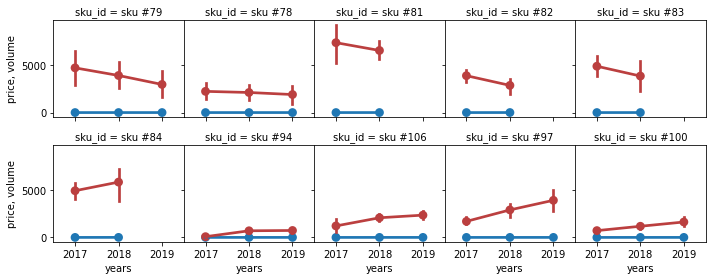

In [45]:
g = sns.FacetGrid(df_s[df_s['sku_id'].isin(df_sku_nan['index'].values)], col="sku_id", col_wrap=5, height=2, margin_titles=True, despine=False)
g.map(sns.pointplot, "year", "price", order=None);
g.map(sns.pointplot, "year", "volume", color="#bb3f3f", order=None);
g.set_axis_labels("years", "price, volume")
g.fig.subplots_adjust(wspace=0)

Красным - продажи  
Синим - цена  


Данные по этим товарам есть за другие года, но есть и такие у кого данные только до 2018 года, т.е. нет ни цен, ни продаж за 2019.  
Т.к. постановка задачи звучит как сделать прогноз продаж на 3 мес с июля 2019, то для корректного предсказания нужны данные до 07.2019, иначе правдоподобность прогноза может быть сомнительной.  

А как обстоят дела с наличием цен и продаж по другим товарами за все года?

In [54]:
%%time
#g = sns.FacetGrid(data=df_s[~df_s['sku_id'].isin(df_sku_nan['index'].values)], col="year", row="sku_id", height=2)#, col_wrap=11, height=2)
#g.map(sns.pointplot, "month", "volume", color="#bb3f3f");

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 12.2 µs


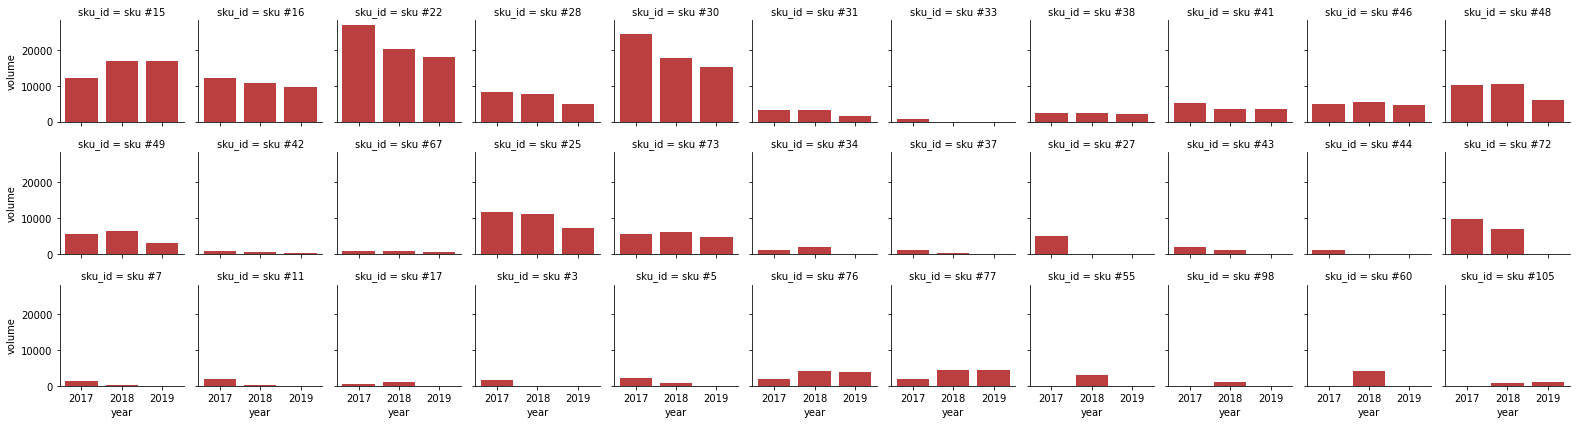

In [52]:
g = sns.FacetGrid(data=df_s[~df_s['sku_id'].isin(df_sku_nan['index'].values)], col="sku_id", col_wrap=11, height=2)
g.map(plt.bar, "year", "volume", color="#bb3f3f");

Тоже существуют товары у которых нет данных по продажам за 2019 год.

#### Динамика продаж товаров за полный период

In [12]:
#Создам новый столбец с датой
df_s['date'] = df_s[['year','month']].apply(lambda r: '{}-{}'.format(r['year'], r['month']), axis=1)
df_s['date'] = pd.to_datetime(df_s['date'])

In [64]:
sns.color_palette("Set2", len(df_s['ira'].unique()))

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411)]

In [58]:
#палитра цветов для городов
colors_ira = dict(zip(df_s['location'].unique(), sns.color_palette("Set2", len(df_s['ira'].unique()))))

/usr/local/lib/python3.9/site-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


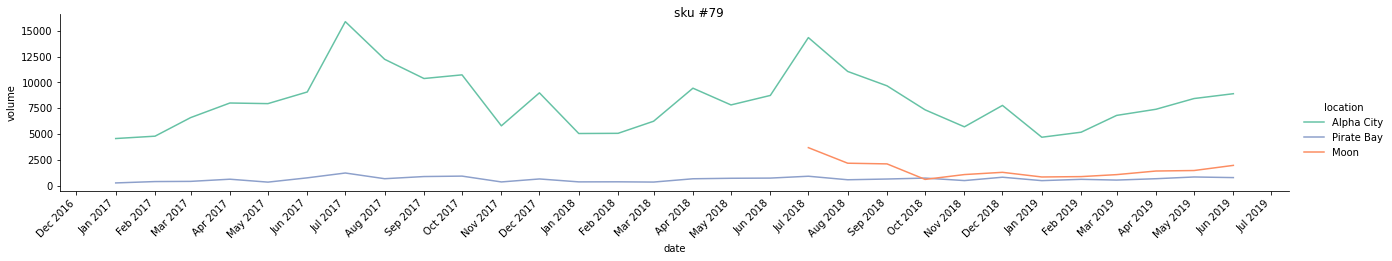

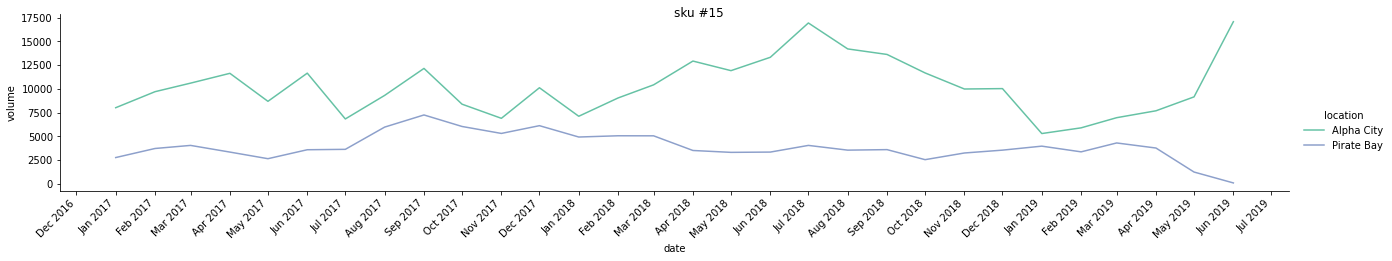

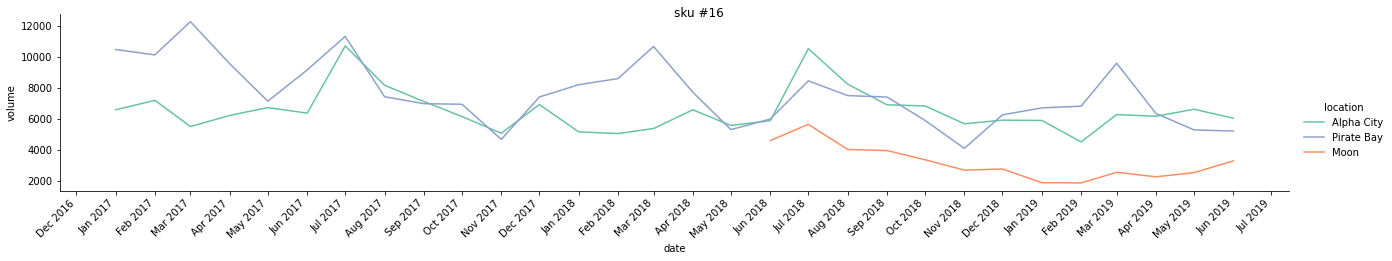

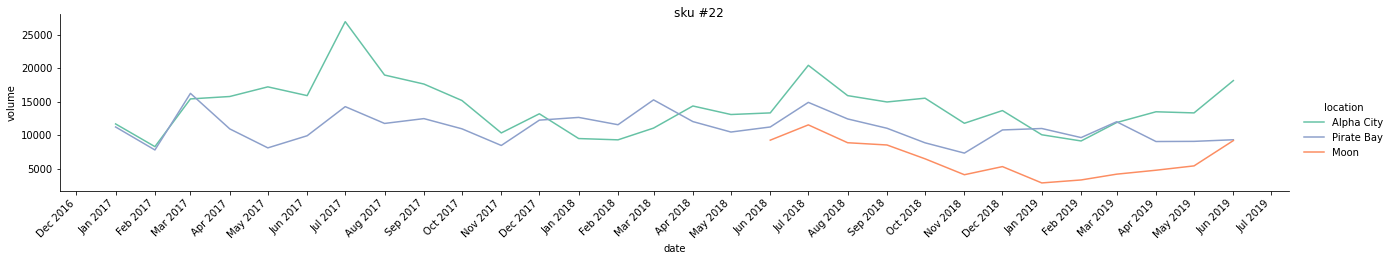

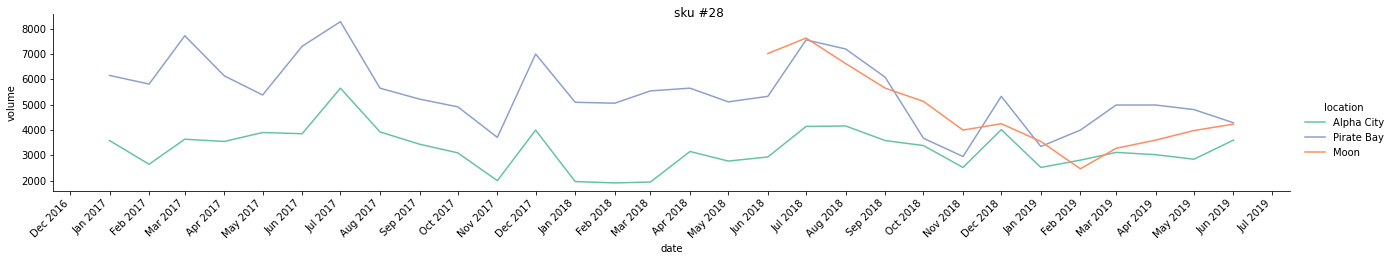

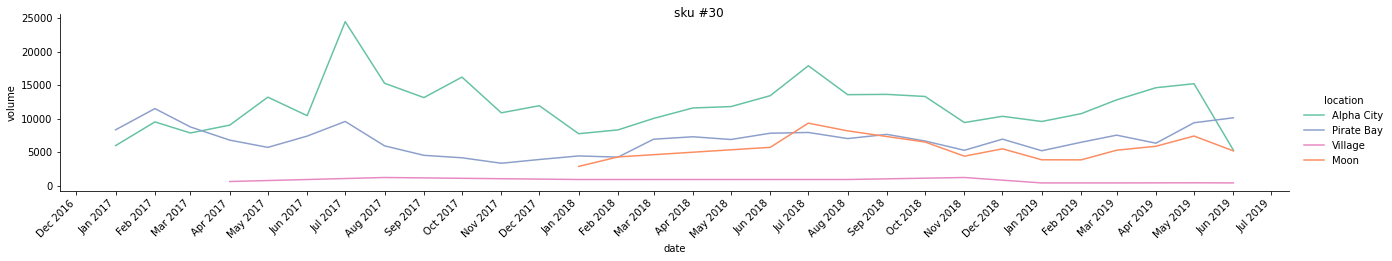

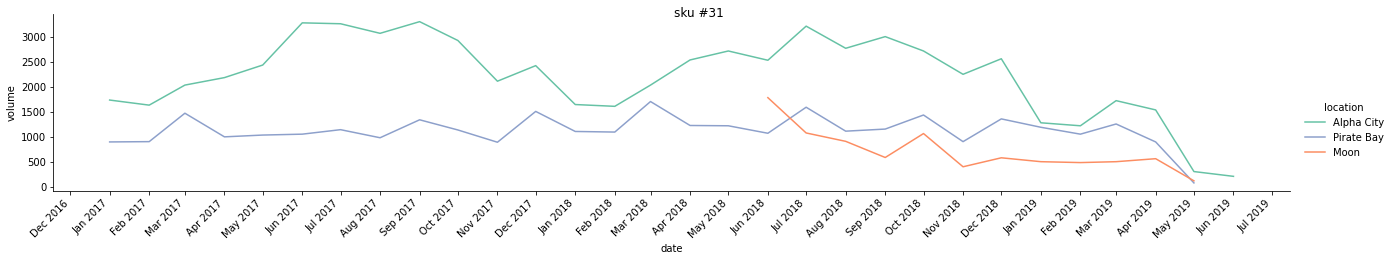

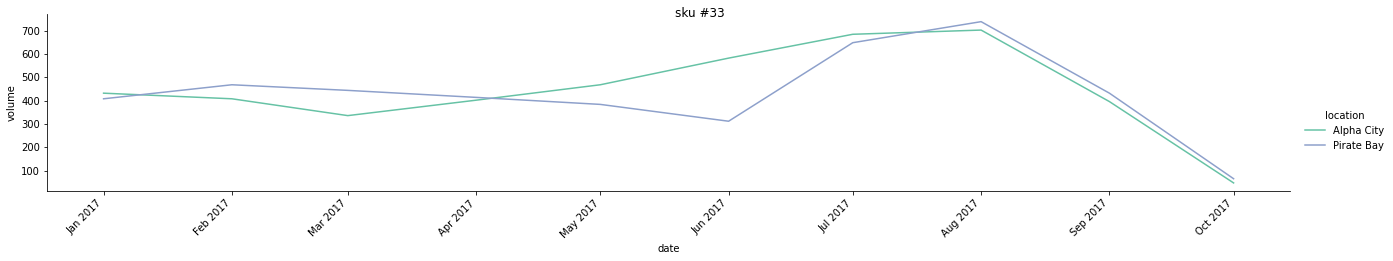

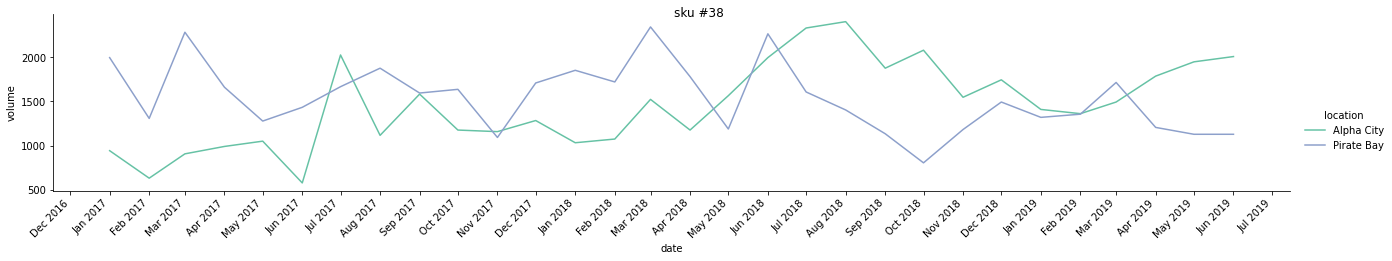

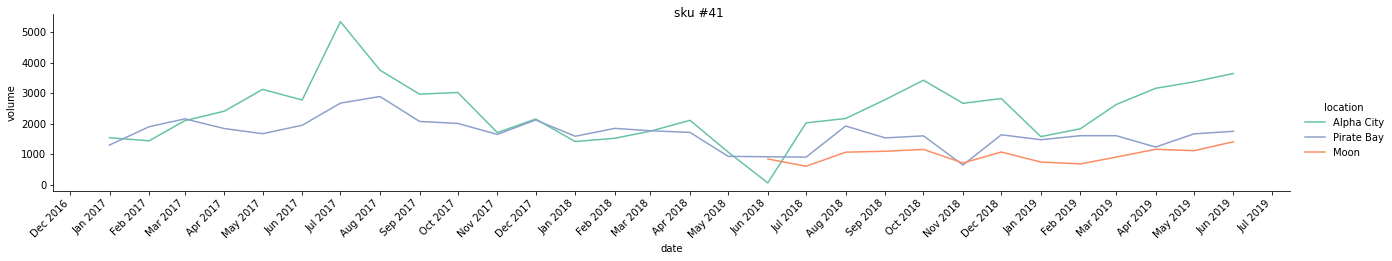

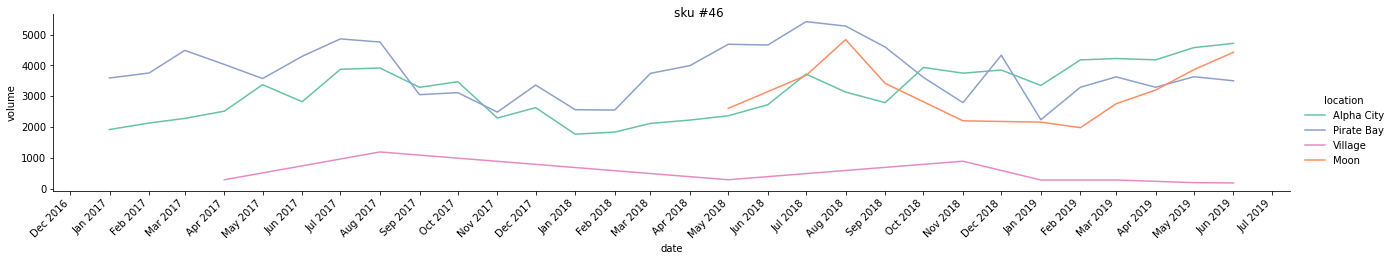

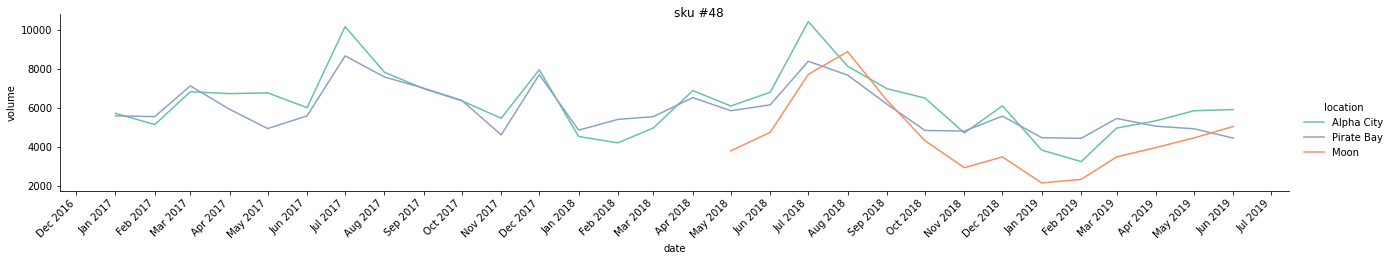

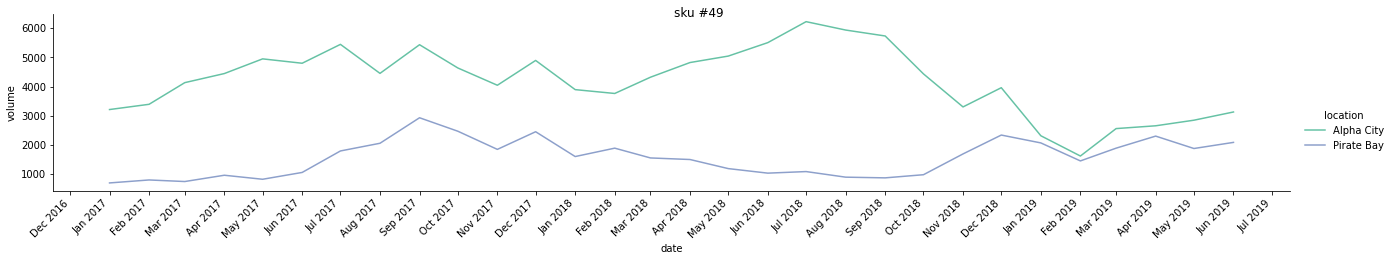

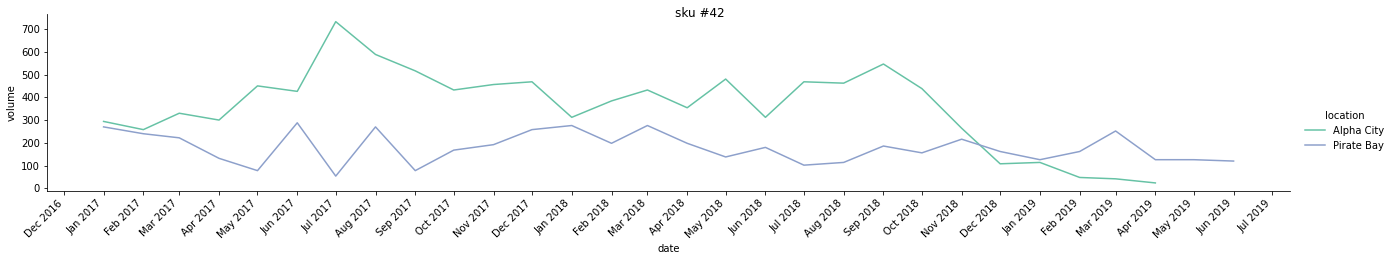

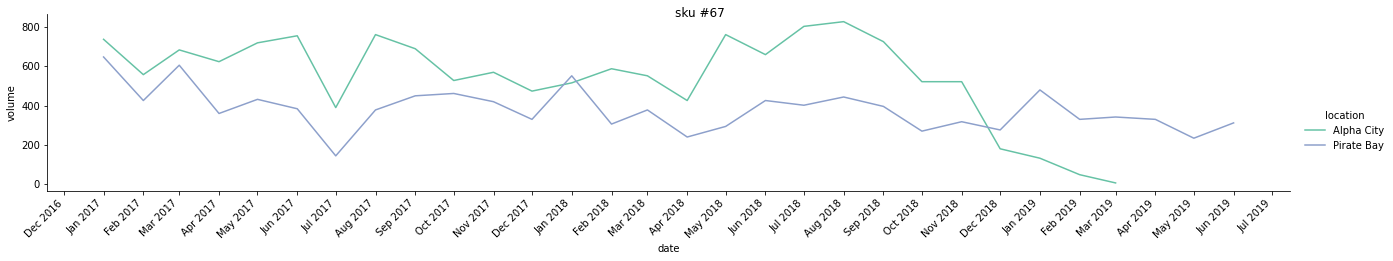

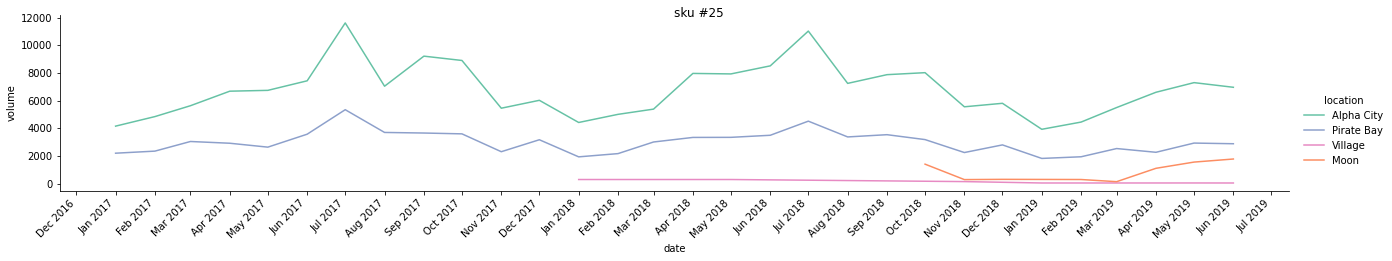

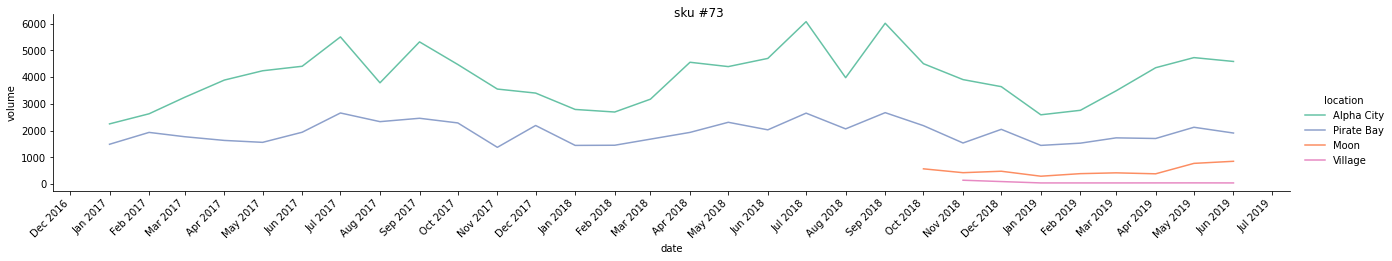

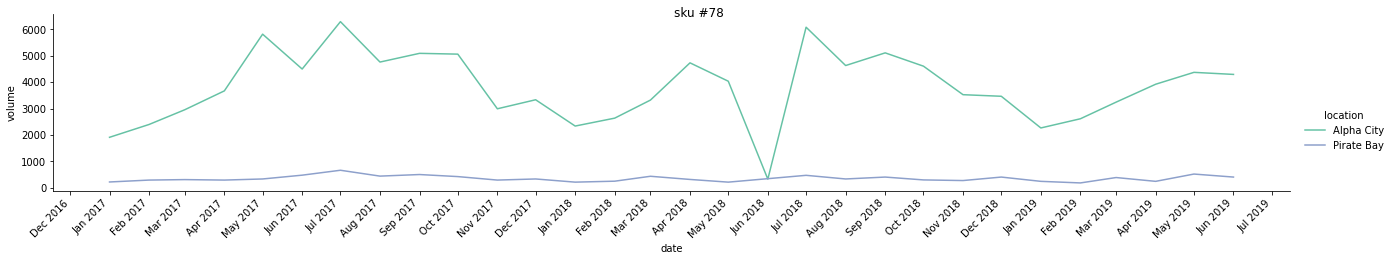

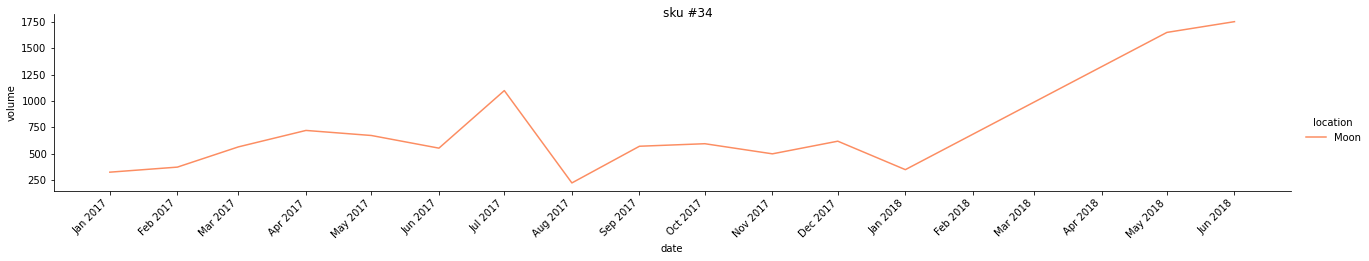

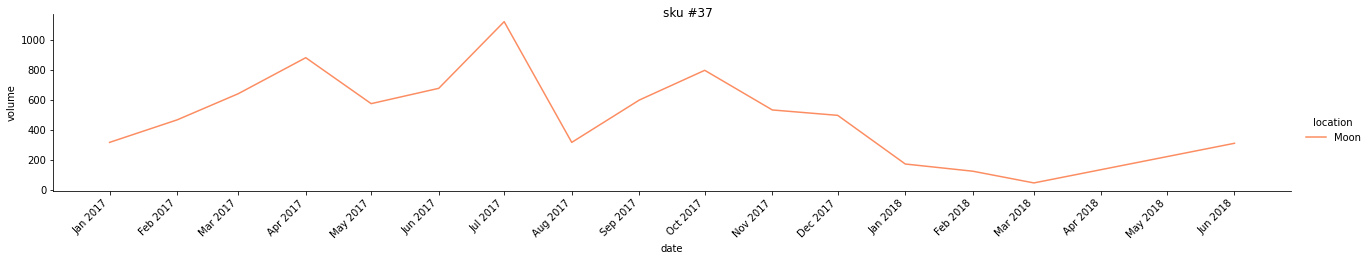

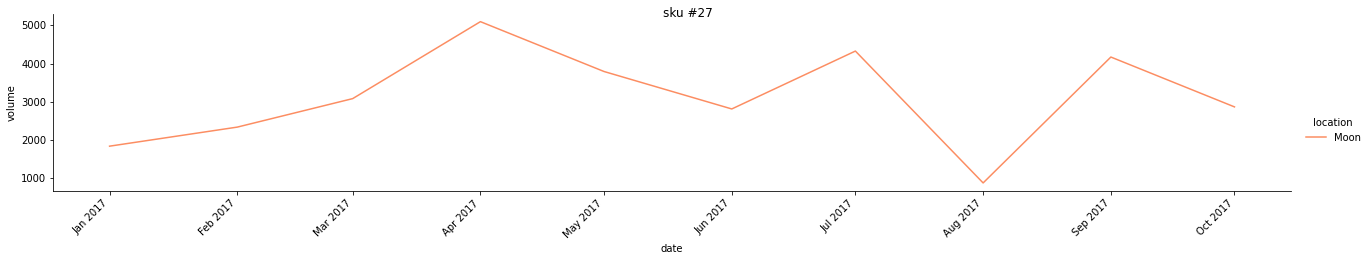

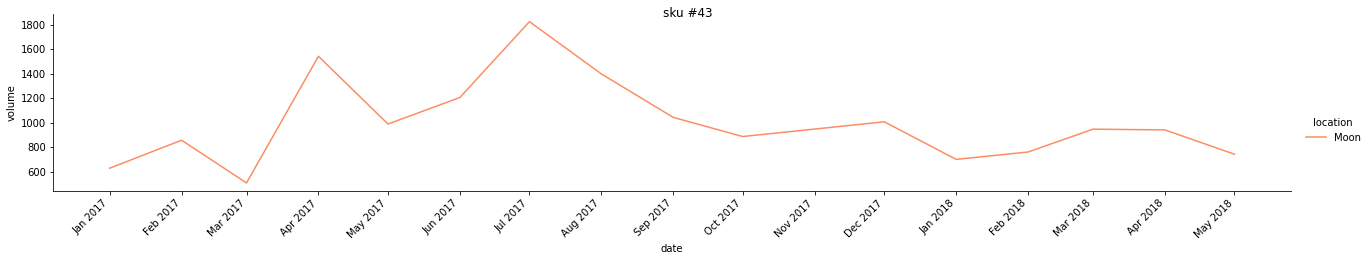

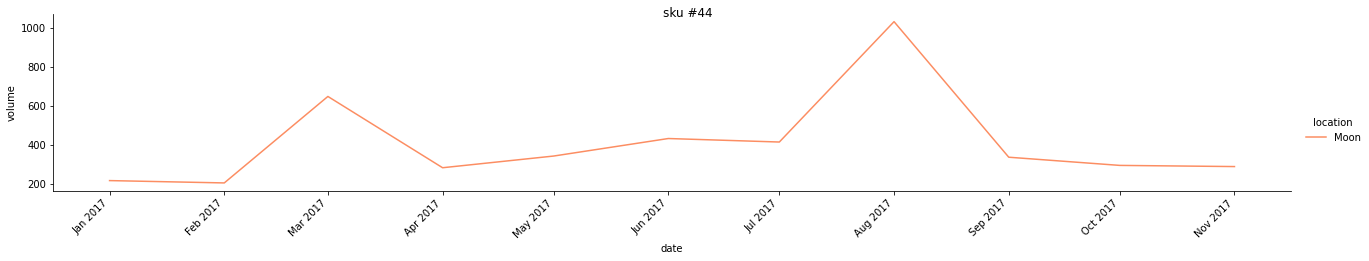

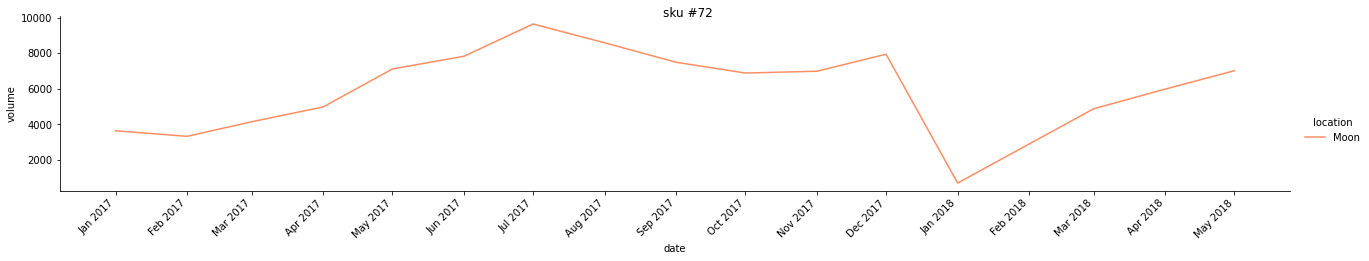

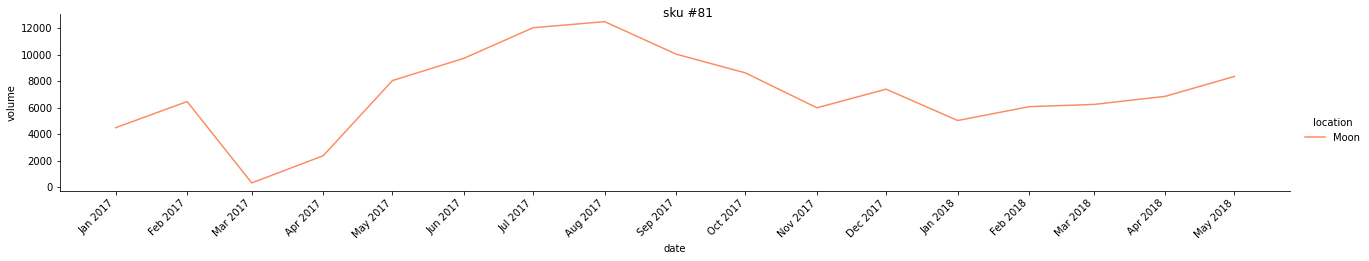

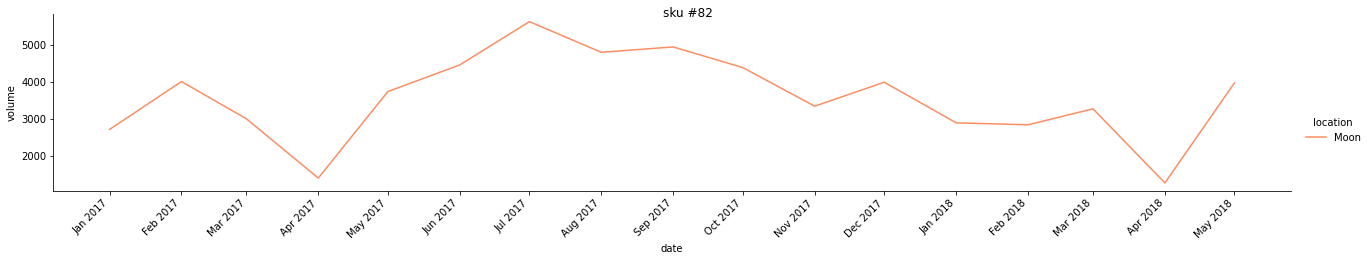

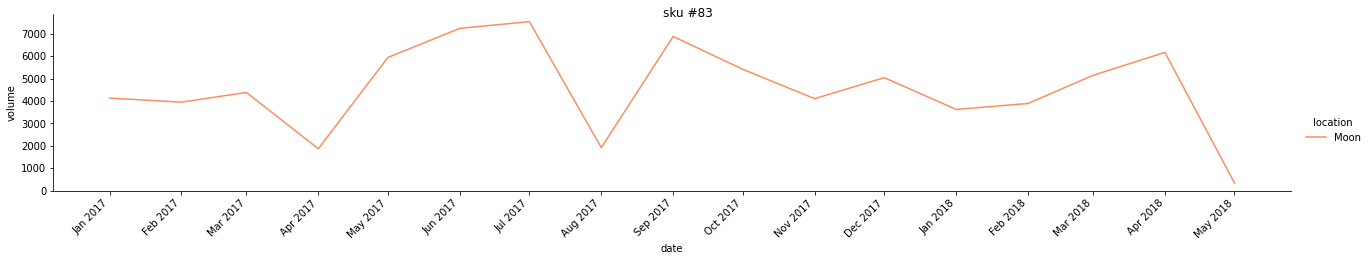

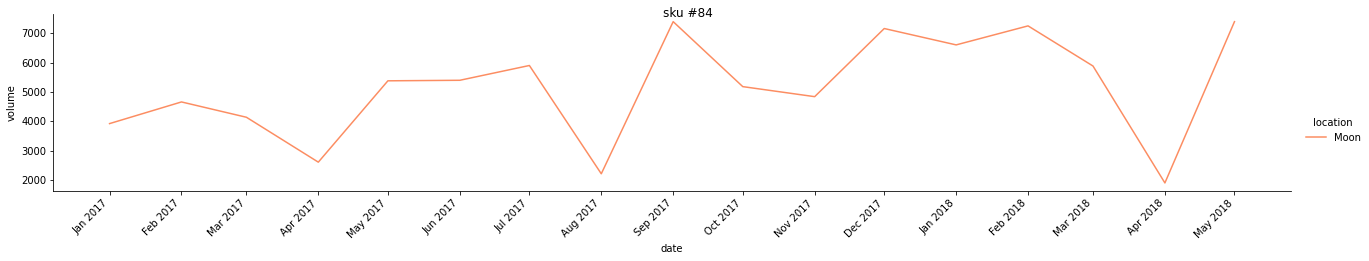

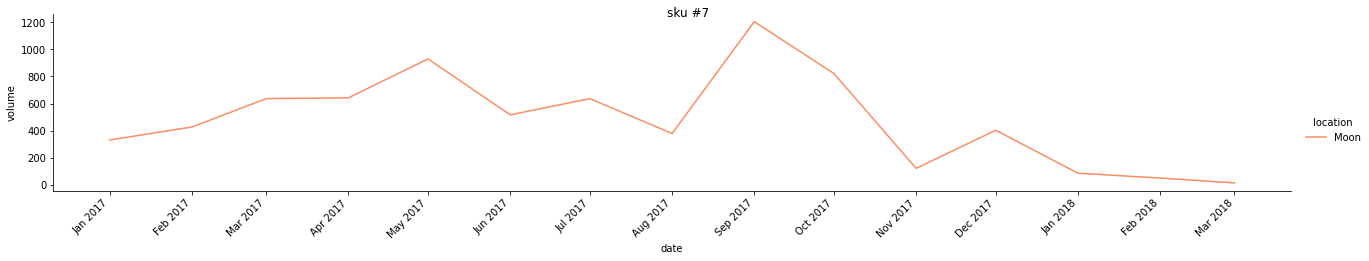

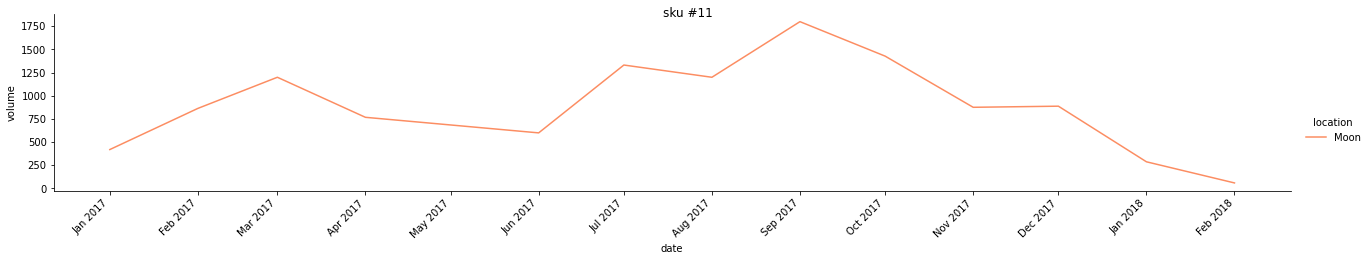

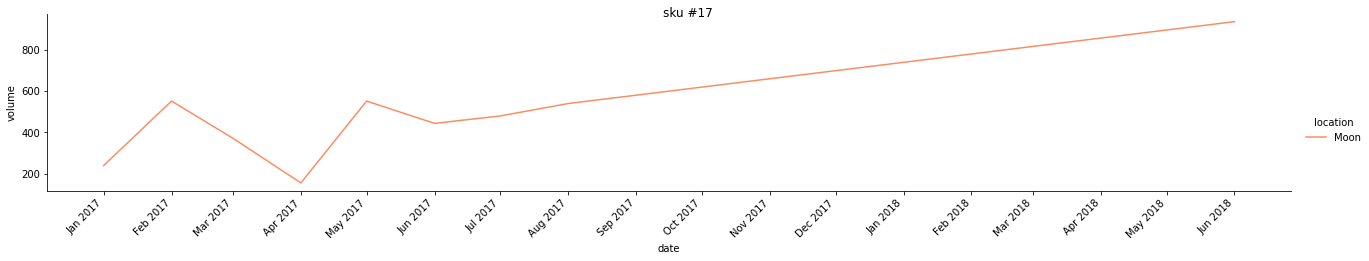

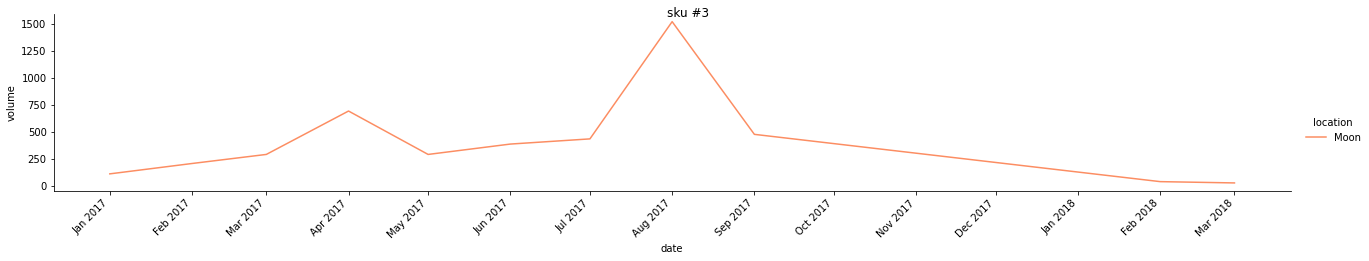

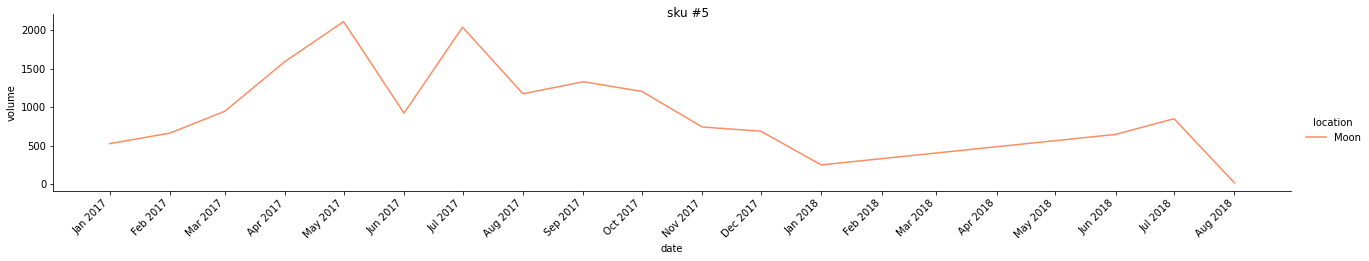

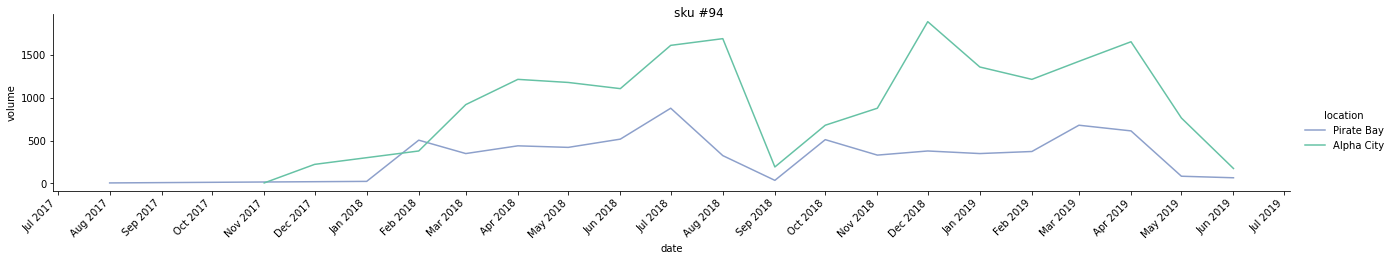

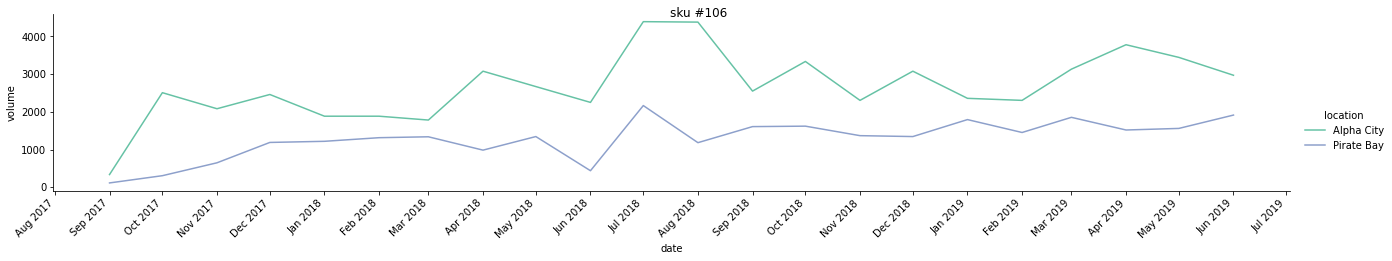

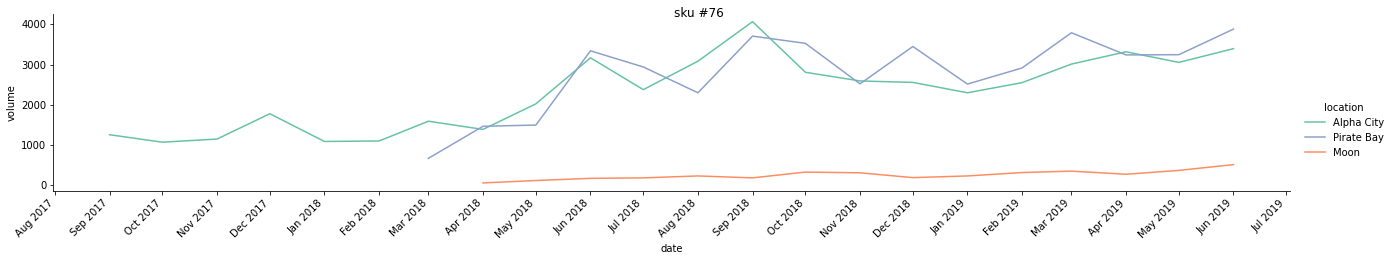

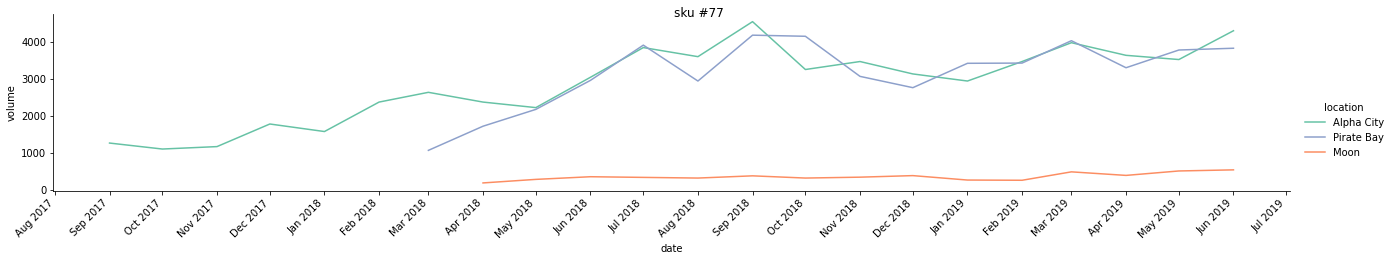

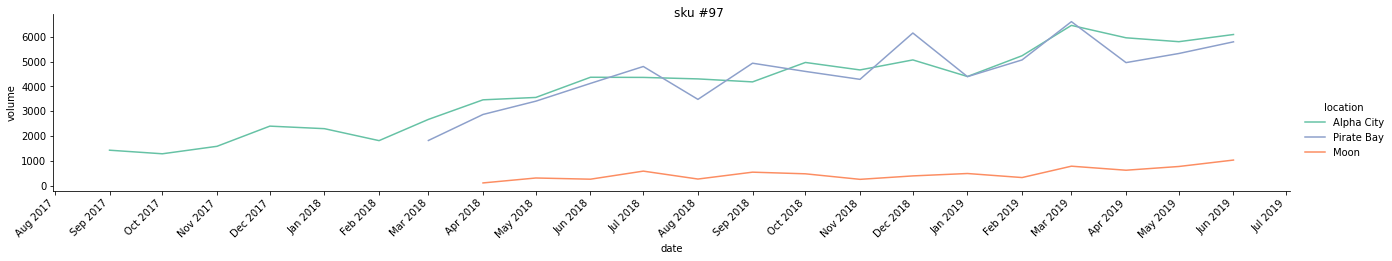

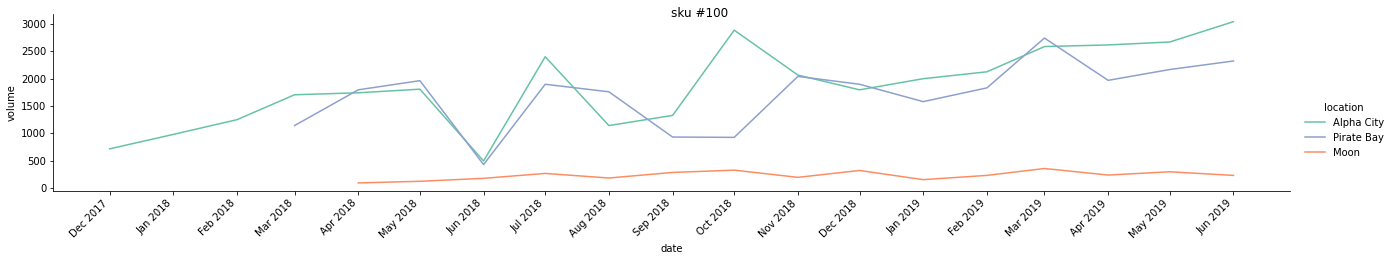

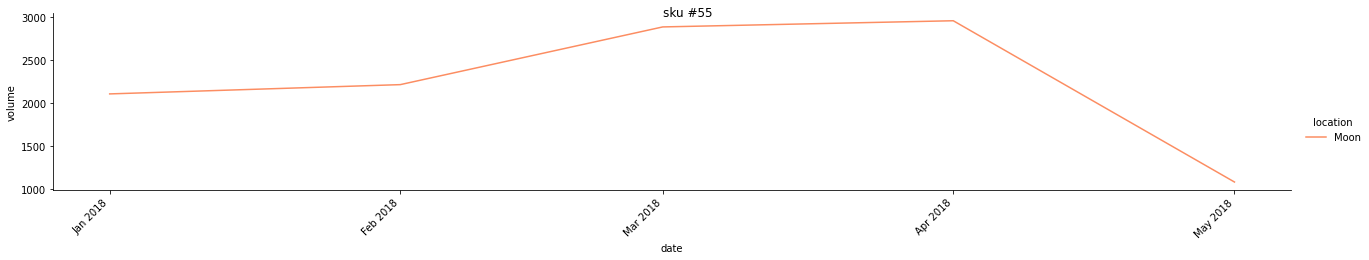

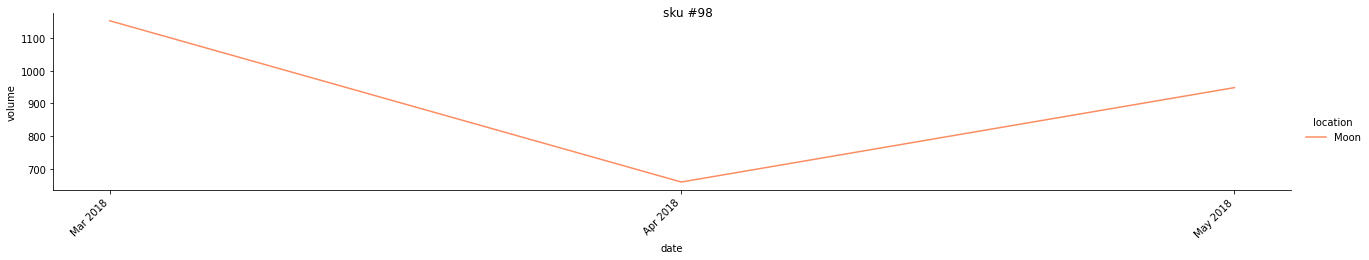

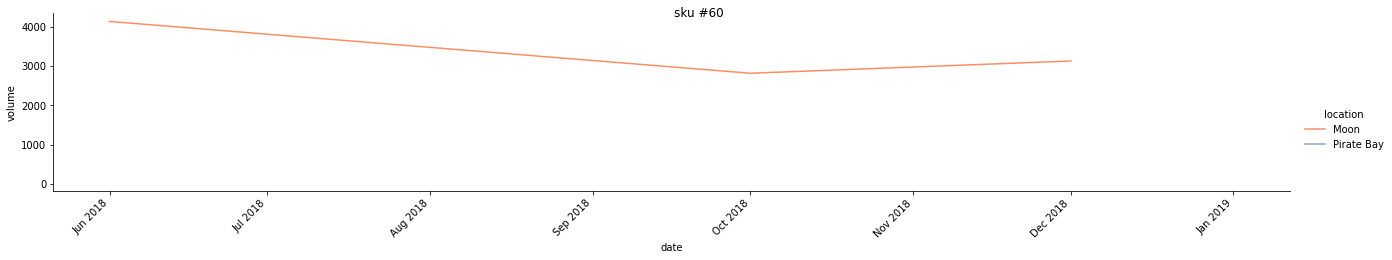

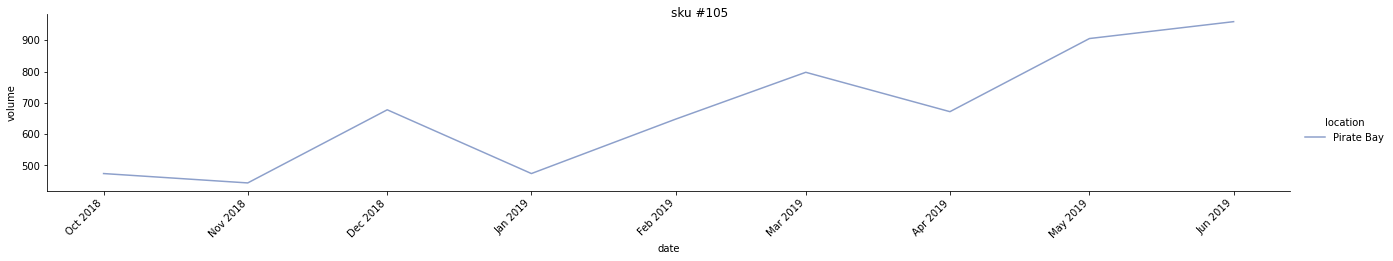

In [78]:
for sku in df_s['sku_id'].unique():
    data=df_s[df_s['sku_id']==sku]
    g=sns.relplot(
        data=data,
        x="date", y="volume",
        hue="location", 
        kind="line", palette=colors_ira,
        height=3, aspect=6, facet_kws=dict(sharex=False),
    )
    g.ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=1))
    g.ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
    plt.setp(g.ax.get_xticklabels(), rotation=45, ha="right")
    g.fig.suptitle(sku);

Какие наблюдения можно сделать:  
 - некоторые товары продаются только в определенных городах всегда
 - некоторые товары продавались только в определенных городах до определенного периода, затем перестали продавать вообще
 - часть товаров не поступало в часть городов до определенного момента или перестало поступать после
 - по части товаров данные по продаже есть не за каждый месяц, а например по квартально
 - есть товары, у которых слишком маленькая история продаж в определенных городах, т.е. продаются там относительно недавно 
 - по нескольким товарам много пиков продаж в июле, видимо связано с отпусками, но есть и товары у которых в июле есть провалы в продажах
 - есть товары, которые стабильно продавались, но затем продажи упали и они вовсе исчезли из оборота
 - есть товары у которых продажи падали до минимума а затем восстановились до пиков
 - есть товары по которым долгое время не было данных по продаже и затем появились

#### Продажи все товаров внутри города

In [60]:
sns.color_palette("turbo_r", len(df_s['sku_id'].unique()))

[(0.54583, 0.03593, 0.00638),
 (0.61923, 0.06367, 0.0041),
 (0.68602, 0.09536, 0.00481),
 (0.74617, 0.13098, 0.00851),
 (0.79971, 0.17055, 0.0152),
 (0.83926, 0.20654, 0.02305),
 (0.88066, 0.25334, 0.03521),
 (0.91572, 0.3053, 0.05134),
 (0.94538, 0.36638, 0.07461),
 (0.96904, 0.43399, 0.10294),
 (0.9859, 0.50479, 0.13367),
 (0.99419, 0.56386, 0.15918),
 (0.99654, 0.63193, 0.18738),
 (0.98986, 0.69382, 0.21043),
 (0.97323, 0.74682, 0.22536),
 (0.94489, 0.79634, 0.228),
 (0.91317, 0.83576, 0.22328),
 (0.86709, 0.87968, 0.21391),
 (0.8141, 0.91861, 0.20552),
 (0.75617, 0.95121, 0.20343),
 (0.69525, 0.9761, 0.21294),
 (0.63323, 0.99195, 0.23937),
 (0.57357, 0.99817, 0.27712),
 (0.48879, 0.99828, 0.33816),
 (0.39678, 0.99098, 0.41098),
 (0.30513, 0.97697, 0.48987),
 (0.22142, 0.95692, 0.56914),
 (0.16319, 0.93609, 0.63137),
 (0.11374, 0.90673, 0.69651),
 (0.0932, 0.87211, 0.75237),
 (0.10026, 0.82955, 0.81389),
 (0.12698, 0.78037, 0.8759),
 (0.16529, 0.7262, 0.93161),
 (0.20021, 0.67842, 0.96833),
 (0.23874, 0.61931, 0.99485),
 (0.26592, 0.55979, 0.99583),
 (0.27543, 0.50115, 0.96594),
 (0.27691, 0.44145, 0.91328),
 (0.27429, 0.39043, 0.85393),
 (0.26652, 0.32768, 0.76412),
 (0.25369, 0.26327, 0.65406),
 (0.23582, 0.1972, 0.52373),
 (0.21291, 0.12947, 0.37314)]

In [62]:
colors_sku = dict(zip(df_s['sku_id'].unique(), sns.color_palette("turbo_r", len(df_s['sku_id'].unique()))))

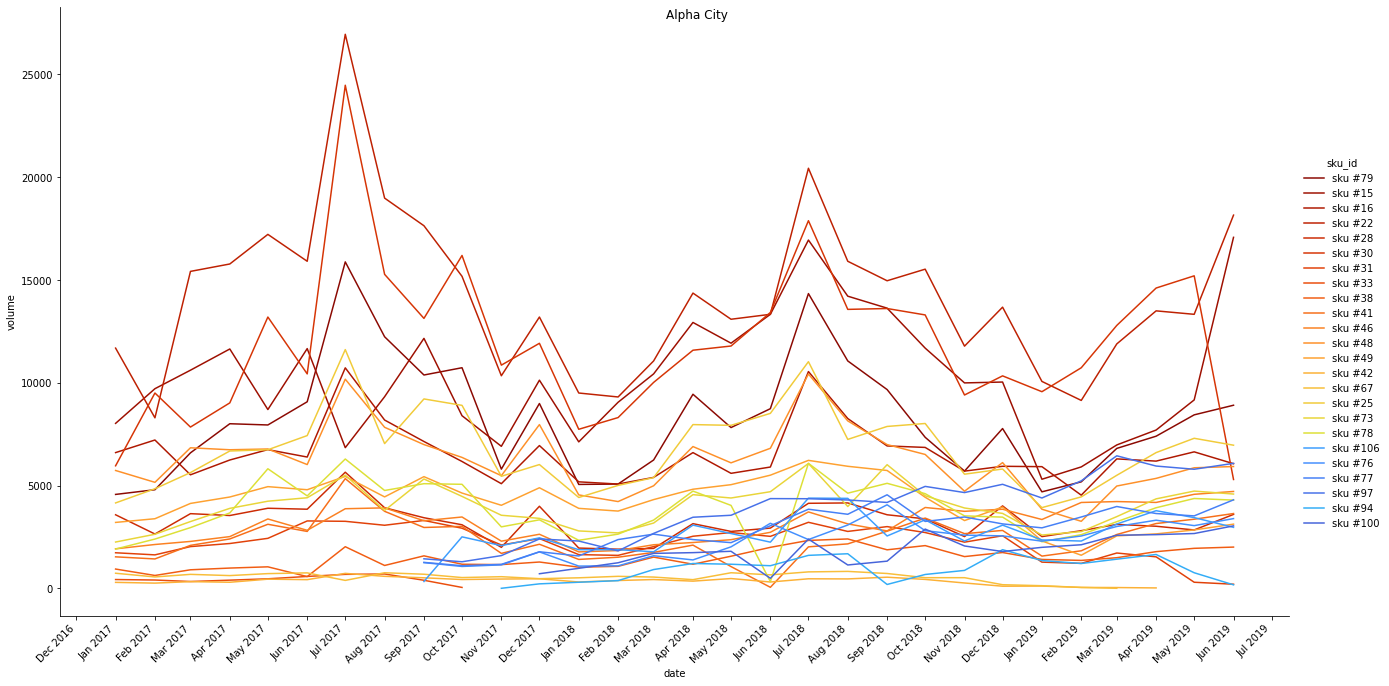

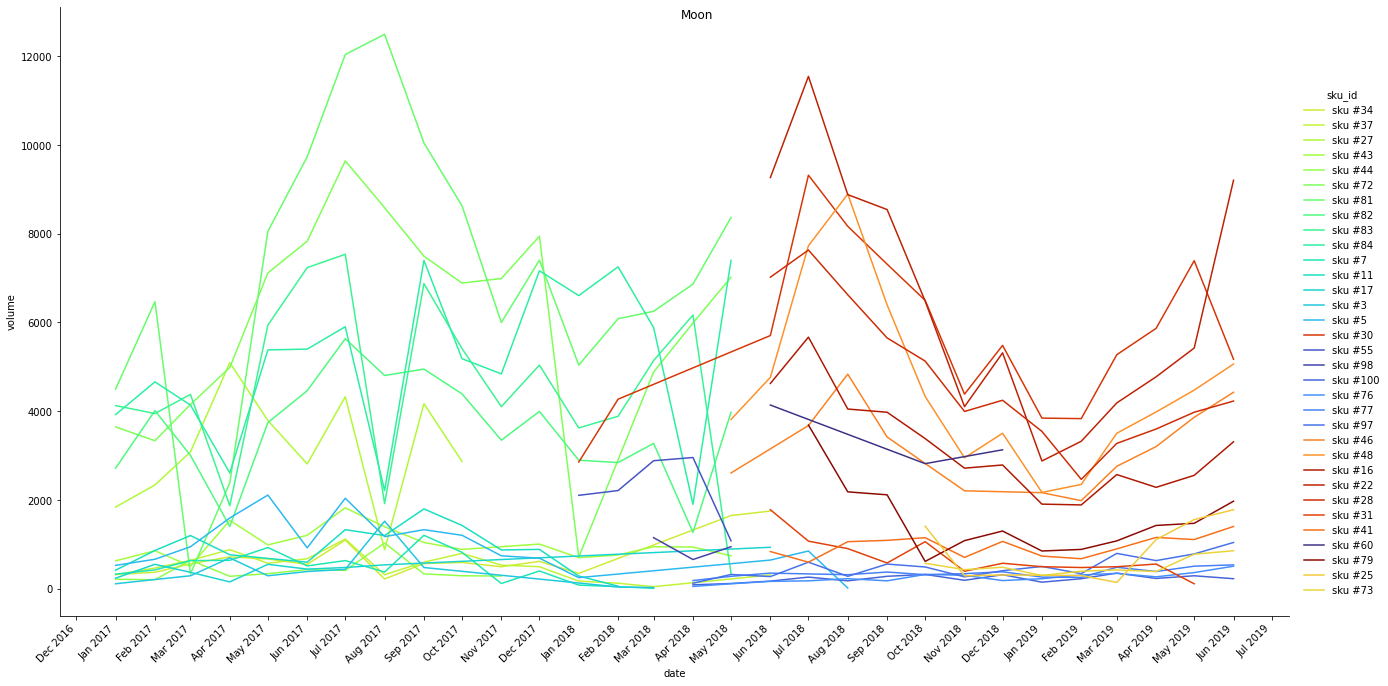

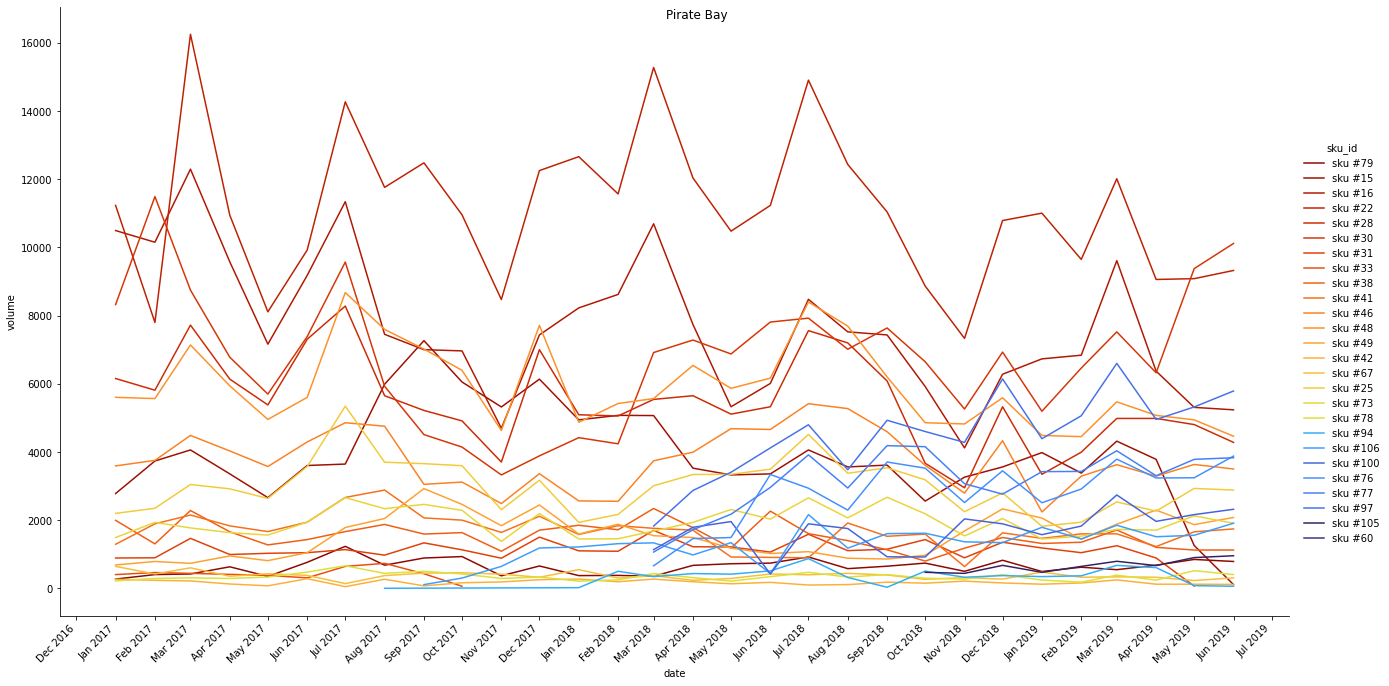

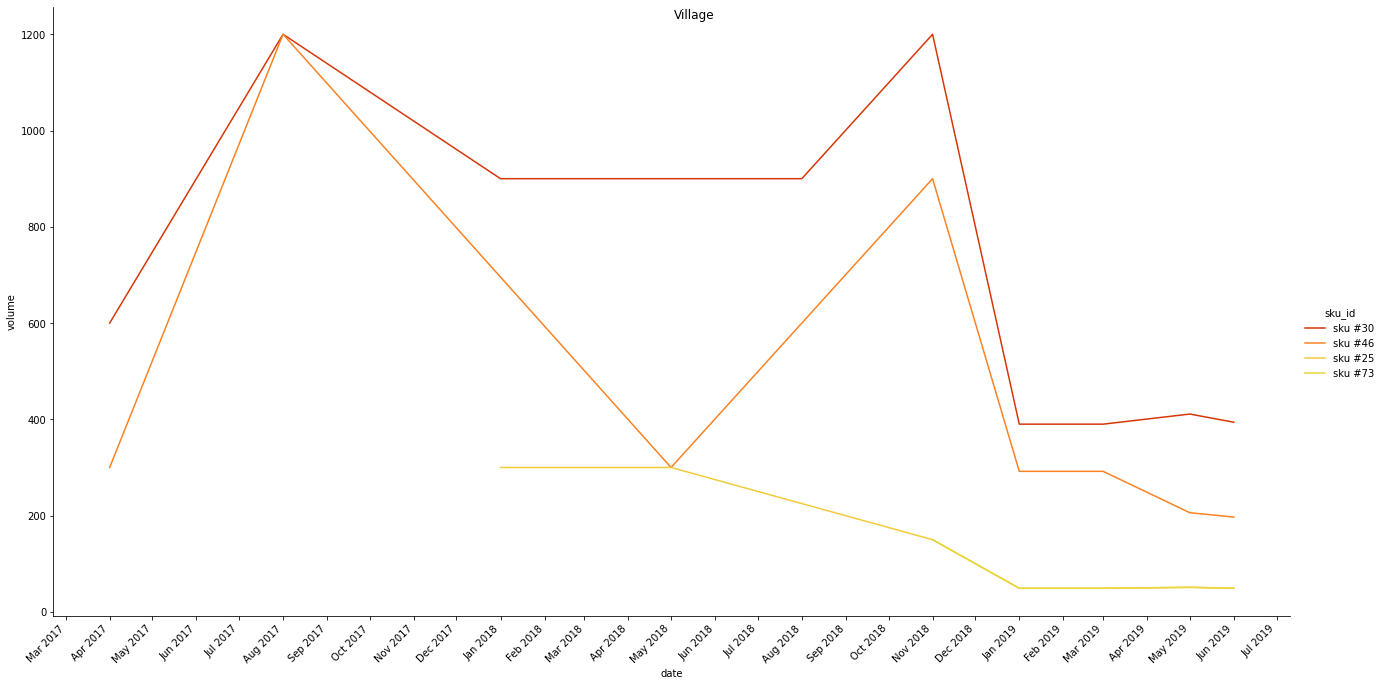

In [82]:
for loc in df_s['location'].unique():
    data=df_s[df_s['location']==loc]
    g=sns.relplot(
        data=data,
        x="date", y="volume",
        hue="sku_id", 
        kind="line", palette=colors_sku,
        height=9, aspect=2, facet_kws=dict(sharex=False),
    )
    g.ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=1))
    g.ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
    plt.setp(g.ax.get_xticklabels(), rotation=45, ha="right")
    g.fig.suptitle(loc);

Какие наблюдения можно сделать:
 - не все товары которые продаются в конкретном городе продавались там всегда, какие то появлялись позже, какие то переставали продаваться
 - например в городе "Moon" сначала продавались одни товары (причем эти товары продавались только тут), затем, был полностью изменен ассортимент на другие товары
 - какие то товары в одних городах начали продаваться раньше чем в других
 - по многим товарам пики продаж совпадают
 - по "Village", продается всего 4 товара, данные по продажам есть раз в несколько месяцев, видимо название говорит само за себя, в деревне спрос не большой и нет необходимости в большом ассортименте и поставкам товаров каждый месяц и с ноября 2018 все продажи резко упали

#### Какие товары продаются лучше?

Средние продажи всех товаров за весь период:

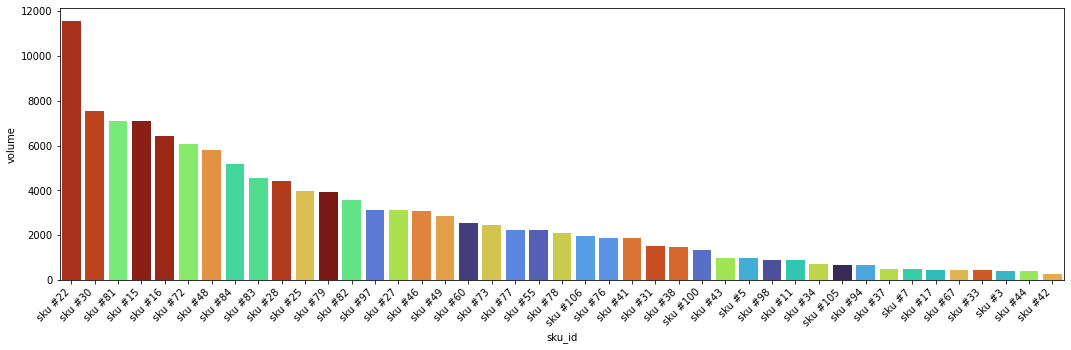

In [198]:
fsize = (18, 5)
fig, ax = plt.subplots(figsize=fsize)
data = df_s.groupby('sku_id')['volume'].mean().reset_index().sort_values('volume', ascending=False)
sns.barplot(data=data, x='sku_id', y='volume', palette=colors_sku);
plt.setp(ax.get_xticklabels(), rotation=45, ha="right");

По годам:

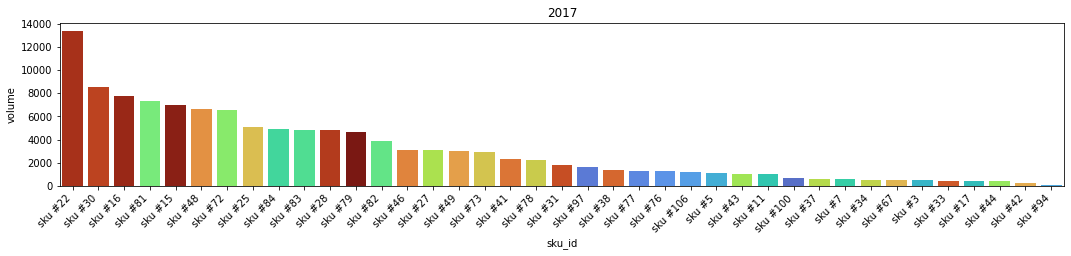

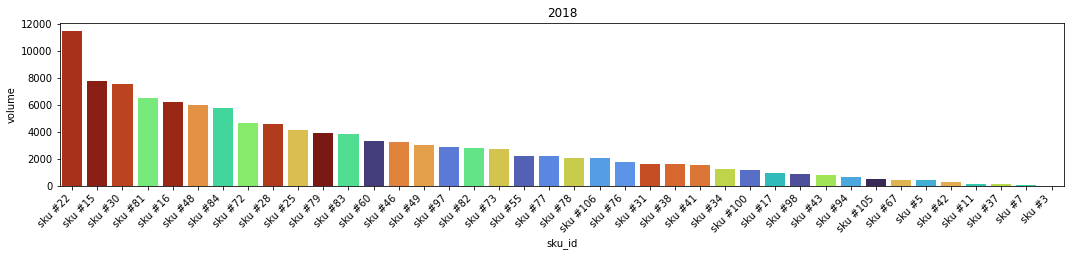

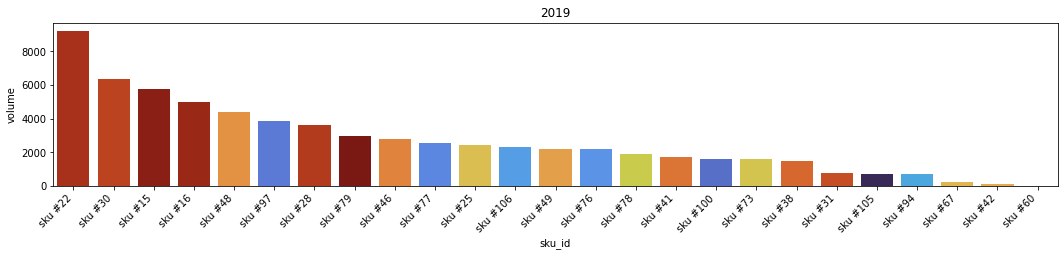

In [160]:
for year in df_s['year'].unique():
    fsize = (18, 3)
    fig, ax = plt.subplots(figsize=fsize)
    data = df_s[df_s['year']==year].groupby('sku_id')['volume'].mean().reset_index().sort_values('volume', ascending=False)
    plt.title(year)
    sns.barplot(data=data, x='sku_id', y='volume', palette=colors_sku);
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right");

Если в 2017 и 2018 годах топ 10 товаров по продажам был примерно одинаковый, то в 2019 году топ изменился, часть товаров вообще исчезла из продаж, например 'sku #81', 'sku #84' да и в целом "зеленые" товары.

Посмотрим на средние продажи топ 10 товаров в каждом городе:

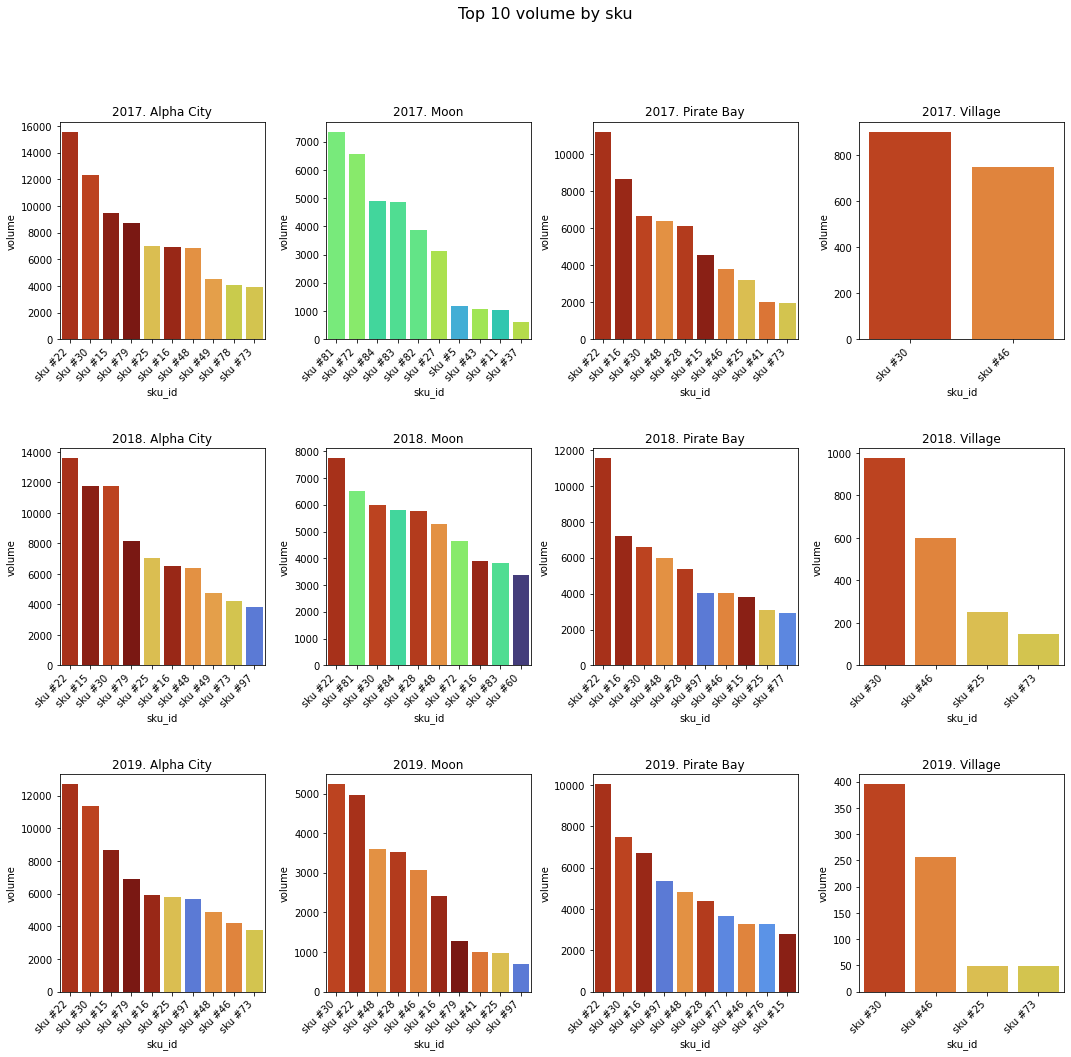

In [197]:
data = df_s.groupby(['sku_id','year','location'])['volume'].mean().reset_index()
years = data['year'].unique()
locations = data['location'].unique()

fig, axes = plt.subplots(nrows=len(years), ncols=len(locations), figsize=(18, 16))
fig.suptitle('Top {} volume by sku'.format(top_sku_volume), fontsize=16)

top_sku_volume = 10

for row, row_axes in enumerate(axes):
    year = years[row]
    data_row = data[data['year'] == year]
    i=0
    for column, ax in enumerate(row_axes):
        location = locations[i]
        top_in_loc = data_row[data_row['location'] == location].sort_values('volume', ascending=False).head(top_sku_volume)
        sns.barplot(data=top_in_loc, x='sku_id', y='volume', palette=colors_sku, ax=ax);
        ax.set_title('{}. {}'.format(year, location))
        i+=1
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    plt.subplots_adjust(hspace=0.5, wspace=0.3)


Интересно как в Moon менялся ассортимент, сначала все "зеленые" товары были на половину заменены на "коричневые" а затем вовсе ушли.  
А в Viliage ассортимент увеличился в 2 раза! :)

In [117]:
data = df_s.groupby(['sku_id','location'])['volume'].mean().reset_index().pivot_table('volume', 'sku_id', 'location')
data.fillna(0, inplace=True)
data = data.nlargest(10, df_s['location'].unique())

In [136]:
data

location,Alpha City,Moon,Pirate Bay,Village
sku_id,,,,
sku #22,14189.366667,6456.000000,11106.4,0.000000
sku #30,11900.866667,5692.400000,6792.4,714.583333
sku #15,10253.600000,0.000000,3914.0,0.000000
sku #79,8159.400000,1558.000000,638.6,0.000000
sku #25,6776.400000,864.000000,2997.0,124.625000
sku #16,6556.200000,3210.923077,7674.6,0.000000
sku #48,6262.866667,4566.857143,5925.2,0.000000
sku #49,4196.600000,0.000000,1558.8,0.000000
sku #73,3992.266667,516.000000,1941.4,66.166667


#### Посмотрим на остальные характеристики товара и их влияние на продажи

Для начала нужно понять у товаров с уникальными ИД (sku_id) уникальные характеристики или например есть товары с одинаковым ИД но один содержит алкоголь а другой нет.

In [308]:
df_s_pivot = pd.pivot_table(df_s, values=['volume'], index=['sku_id'], columns=['filling','shape','with_alcohol','item_per_bundle','brand'],
                aggfunc={'volume':'count'}
                )
df_s_pivot.count(axis=1).values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Т.к. все единицы, то уникальные товары имеют уникальные характеристики.

С какими характеристиками товаров продается больше и какие средние продажи:

In [317]:
df_s_pivot = pd.pivot_table(df_s, values=['sku_id', 'volume'], index=[ 'product_category','brand', 'with_alcohol','item_per_bundle'], 
                columns=['filling','shape'], aggfunc={'sku_id':'count', 'volume':'mean'} ,fill_value=0
                ).round(1)
df_s_pivot

sku_id          \
filling                                                      Berries Nothing   
shape                                                         Square  Square   
product_category brand          with_alcohol item_per_bundle                   
Chocolates       Cadbury        No           1                     0       0   
                 Ferrero Rocher No           1                     9      74   
                                             2                     0       0   
                                             3                     0       0   
                                Yes          1                     0       0   
                 Milka          No           1                     0       0   
                 Snickers       No           1                     0       0   
                 Toblerone      No           1                     0       0   
                                             2                     0       0   
                 Twix           No           1                     0       0   
Lollipops        Chupa Chups    No           1                     0       0   
                                Yes          1                     0       0   

                                                                             \
filling                                                                Nuts   
shape                                                        Standart Round   
product_category brand          with_alcohol item_per_bundle                  
Chocolates       Cadbury        No           1                    103     0   
                 Ferrero Rocher No           1                    485     0   
                                             2                    181     0   
                                             3                    180     0   
                                Yes          1                     60     0   
                 Milka          No           1                    115     0   
                 Snickers       No           1                     54     0   
                 Toblerone      No           1                    178     0   
                                             2                     22     0   
                 Twix           No           1                     59     0   
Lollipops        Chupa Chups    No           1                      0   106   
                                Yes          1                      0   103   

                                                              volume          \
filling                                                      Berries Nothing   
shape                                                         Square  Square   
product_category brand          with_alcohol item_per_bundle                   
Chocolates       Cadbury        No           1                   0.0     0.0   
                 Ferrero Rocher No           1                 672.7  1490.4   
                                             2                   0.0     0.0   
                                             3                   0.0     0.0   
                                Yes          1                   0.0     0.0   
                 Milka          No           1                   0.0     0.0   
                 Snickers       No           1                   0.0     0.0   
                 Toblerone      No           1                   0.0     0.0   
                                             2                   0.0     0.0   
                 Twix           No           1                   0.0     0.0   
Lollipops        Chupa Chups    No           1                   0.0     0.0   
                                Yes          1                   0.0     0.0   

                                                                               
filling                                                                  Nuts  
shape                                                        Standart   Rou

"Chupa Chups" с алкоголем ... интересно ...

Больше всего товаров поставляется без начинки, без алкоголя, стандартной формы и единичной упаковки, но средний объем продаж выше у товаров с теми же характеристиками но по 3 и 2 штуки в упаковке.

In [318]:
def volume_for_one_sku(in_table):
    '''
    На основе сводной таблицы объема продаж рассчитывает таблицу объема продаж на единицу товара
    '''
    out_table = in_table
    count_cols = int(len(in_table.columns)/2) #Т.к. у нас в первой половине таблицы количетсво продаж а в правой объем, то нужно левую часть поделить на правую
    for i in range(count_cols): 
        out_table[out_table.columns[i+count_cols]] = in_table[in_table.columns[i+count_cols]] / in_table[in_table.columns[i]]
    
    return out_table.fillna(0).round(1)

In [319]:
volume_for_one_sku(df_s_pivot)

sku_id          \
filling                                                      Berries Nothing   
shape                                                         Square  Square   
product_category brand          with_alcohol item_per_bundle                   
Chocolates       Cadbury        No           1                     0       0   
                 Ferrero Rocher No           1                     9      74   
                                             2                     0       0   
                                             3                     0       0   
                                Yes          1                     0       0   
                 Milka          No           1                     0       0   
                 Snickers       No           1                     0       0   
                 Toblerone      No           1                     0       0   
                                             2                     0       0   
                 Twix           No           1                     0       0   
Lollipops        Chupa Chups    No           1                     0       0   
                                Yes          1                     0       0   

                                                                             \
filling                                                                Nuts   
shape                                                        Standart Round   
product_category brand          with_alcohol item_per_bundle                  
Chocolates       Cadbury        No           1                    103     0   
                 Ferrero Rocher No           1                    485     0   
                                             2                    181     0   
                                             3                    180     0   
                                Yes          1                     60     0   
                 Milka          No           1                    115     0   
                 Snickers       No           1                     54     0   
                 Toblerone      No           1                    178     0   
                                             2                     22     0   
                 Twix           No           1                     59     0   
Lollipops        Chupa Chups    No           1                      0   106   
                                Yes          1                      0   103   

                                                              volume          \
filling                                                      Berries Nothing   
shape                                                         Square  Square   
product_category brand          with_alcohol item_per_bundle                   
Chocolates       Cadbury        No           1                   0.0     0.0   
                 Ferrero Rocher No           1                  74.7    20.1   
                                             2                   0.0     0.0   
                                             3                   0.0     0.0   
                                Yes          1                   0.0     0.0   
                 Milka          No           1                   0.0     0.0   
                 Snickers       No           1                   0.0     0.0   
                 Toblerone      No           1                   0.0     0.0   
                                             2                   0.0     0.0   
                 Twix           No           1                   0.0     0.0   
Lollipops        Chupa Chups    No           1                   0.0     0.0   
                                Yes          1                   0.0     0.0   

                                                                             
filling                                                                Nuts  
shape                                                        Standart Round  
p

Не смотря на то, что товара с Berries от Ferrero Rocher всего 9 позиций продаж, выхлоп на единицу товара у него выше, возможно его стоит поставлять больше...

Подумать как можно использовать данные выше...

In [314]:
df_s[df_s['filling'] == 'Berries']

,year,month,location,ira,product_category,brand,sku_id,item_per_bundle,shape,with_alcohol,filling,volume,price,is_nan,date
1193,2018,10,Pirate Bay,PB,Chocolates,Ferrero Rocher,sku #105,1,Square,No,Berries,474.0,1.298127,False,2018-10-01
1255,2018,11,Pirate Bay,PB,Chocolates,Ferrero Rocher,sku #105,1,Square,No,Berries,444.0,1.277129,False,2018-11-01
1321,2018,12,Pirate Bay,PB,Chocolates,Ferrero Rocher,sku #105,1,Square,No,Berries,678.0,1.253769,False,2018-12-01
1382,2019,1,Pirate Bay,PB,Chocolates,Ferrero Rocher,sku #105,1,Square,No,Berries,474.0,1.263547,False,2019-01-01
1449,2019,2,Pirate Bay,PB,Chocolates,Ferrero Rocher,sku #105,1,Square,No,Berries,648.0,1.349892,False,2019-02-01
1515,2019,3,Pirate Bay,PB,Chocolates,Ferrero Rocher,sku #105,1,Square,No,Berries,798.0,1.400149,False,2019-03-01
1580,2019,4,Pirate Bay,PB,Chocolates,Ferrero Rocher,sku #105,1,Square,No,Berries,672.0,1.389624,False,2019-04-01
1640,2019,5,Pirate Bay,PB,Chocolates,Ferrero Rocher,sku #105,1,Square,No,Berries,906.0,1.389467,False,2019-05-01
1703,2019,6,Pirate Bay,PB,Chocolates,Ferrero Rocher,sku #105,1,Square,No,Berries,960.0,1.339017,False,2019-06-01
